In [ ]:
''' installation requirements for colab'''
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf
!pip install gymnasium[mujoco]
!pip install free-mujoco-py
# !pip install stable-baselines[mpi]
# !pip install tensorflow

In [2]:
import random
import gymnasium as gym
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display

# from multiprocessing import Process, Pipe, cpu_count
# from stable_baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
%matplotlib inline


device   = "cuda" if torch.cuda.is_available() else "cpu"
# random.seed(42)
# np.random.seed(42)
# torch.manual_seed(42)
# torch.backends.cudnn.deterministic = True

In [3]:
class ReplayBuffer():
  def __init__(self, size):
    self.size = size
    self.memory = deque([], maxlen=size)

  def clear(self):
    self.memory.clear()
  
  def insert(self, *args):
    self.memory.append(tuple(args))

  def sample(self, batch_size):
    # indices = list(range(len(self.memory)))
    # random.shuffle(indices)
    # batches = [indices[i:i+batch_size] for i in range(0, len(self.memory), batch_size) if i+batch_size<=len(self.memory)]
    return self.memory#, batches

  def __len__(self):
    return len(self.memory)

In [ ]:
class RescaleActionWrapper(gym.ActionWrapper):
    def action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        return action

In [4]:
def plot(ep, rewards, timesteps):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title('frame %s. reward: %s' % (ep, np.mean(rewards[-100:])))
    plt.plot(rewards)
    start = len(rewards)%100
    mean_rewards = rewards[start:]
    plt.plot(np.arange(1, int(len(mean_rewards)/100)+1)*100, np.mean(np.reshape(mean_rewards, (int(len(mean_rewards)/100), 100)), 1), color='r')
    plt.subplot(122)
    plt.title('frame %s. timesteps: %s' % (ep, np.mean(timesteps[-100:])))
    plt.plot(timesteps)
    start = len(rewards)%100
    mean_timesteps = timesteps[start:]
    plt.plot(np.arange(1, int(len(mean_timesteps)/100)+1)*100, np.mean(np.reshape(mean_timesteps, (int(len(mean_timesteps)/100), 100)), 1), color='r')
    plt.show()

In [5]:
class ValueNetwork(nn.Module):
    def __init__(self, n_states, n_actions, n_hidden):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(n_states, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, 1)
        
    def forward(self, state):
        x = F.tanh(self.linear1(state))
        x = F.tanh(self.linear2(x))
        return self.linear3(x)

In [6]:
class PolicyNetwork(nn.Module):
    def __init__(self, n_states, n_actions, n_hidden, log_std_min=-10, log_std_max=2):
        super(PolicyNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(n_states, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        
        self.mean = nn.Linear(n_hidden, n_actions)
        # self.log_std = nn.Linear(n_hidden, n_actions)
        self.log_std = nn.Parameter(torch.zeros(1, np.prod(envs.single_action_space.shape)))

    def forward(self, state):
        x = F.tanh(self.linear1(state))
        x = F.tanh(self.linear2(x))
        mean = self.mean(x)
        # print(mean)
        self.log_std.expand_as(mean)
        std = self.log_std.exp()
        # log_std = self.log_std(x)
        # std = torch.clamp(log_std, self.log_std_min, self.log_std_max).exp()
        # std = log_std.log()
        # print(mean)
        # print(std) 
        dist = Normal(mean, std)
        action = dist.sample()
        return action, dist

In [ ]:
def standard_normalize(inp):
  std, mean = torch.std_mean(inp)
  return (inp-mean)/std

In [7]:
def update(batch_size, gamma, lambd, epsilon, update_iterations, last_state, last_done, update_steps):
  memory = replay.sample(batch_size)
  states, actions, rewards, old_log_probs, old_values, dones = map(np.stack, zip(*memory))
  old_values = old_values.squeeze()
  advantages = np.zeros_like(rewards)
  last_value = v_net(torch.tensor(last_state, dtype=torch.float32).to(device))
  for t in range(num_trajectories-1, -1, -1):
    if t == num_trajectories-1:
      terminals = 1-np.array(last_done)
      next_values = last_value.cpu().detach().numpy().squeeze()
    else:
      terminals = 1-dones[t+1]
      next_values = old_values[t+1]
    td = rewards[t] + gamma*terminals*next_values - old_values[t]
    if t == num_trajectories-1:
      advantages[t] = td
    else:
      advantages[t] = td + gamma*lambd*terminals*advantages[t+1]
  advantages = torch.FloatTensor(advantages)
  returns = advantages + old_values

  # for t in range(len(rewards)-1):
  #   discount = 1
  #   adv = 0
  #   for k in range(t, len(rewards)-1,):
  #     adv += discount*(rewards[k] + gamma*old_values[k+1]*(1-dones[k]) - old_values[k])
  #     discount = discount*gamma*lambd
  #   advantages[t] = adv
  # advantages = torch.FloatTensor(advantages).unsqueeze(1).to(device)
  # old_values = torch.FloatTensor(old_values).to(device)
  states = torch.FloatTensor(states.reshape(-1, test_env.observation_space.shape[0])).to(device)
  actions = torch.FloatTensor(actions.reshape(-1, test_env.action_space.shape[0])).to(device)
  returns = torch.FloatTensor(returns.reshape(-1)).to(device)
  old_log_probs = torch.FloatTensor(old_log_probs.reshape(-1, test_env.action_space.shape[0])).to(device)
  old_values = torch.FloatTensor(old_values.reshape(-1)).to(device)
  advantages = torch.FloatTensor(advantages.reshape(-1)).to(device)

  batches = list(range(nenvs*num_trajectories))
  for iter in range(update_iterations):
    random.shuffle(batches)
    mini_batches = [batches[i:i+batch_size] for i in range(0, len(batches), batch_size)]
    running_policy_loss = []
    running_value_loss = []
    running_entropy_loss = []
    running_total_loss = []
    for i, batch in enumerate(mini_batches):
      # states, actions, _, old_log_probs, old_values, dones = map(np.stack, zip(*batches))
      state = states[batch]
      # print(i)
      # print(old_log_probs[batch].shape)
      old_log_prob = old_log_probs[batch].sum(1)
      # old_log_prob = old_log_prob.sum(1)
      action = actions[batch]
      value = v_net(state).squeeze()
      _, dist = policy_net(state)
      log_prob = dist.log_prob(action).sum(1)
      # log_prob = log_prob
      policy_ratio = (log_prob - old_log_prob).exp()
      surrogate_loss = advantages[batch] * policy_ratio
      surrogate_loss_clipped = advantages[batch]*torch.clamp(policy_ratio, 1-epsilon, 1+epsilon)

      policy_loss = -torch.min(surrogate_loss, surrogate_loss_clipped).mean()

      # returns = advantages[batch].squeeze() + old_values[batch]
      value_loss = torch.square(returns[batch]-value).mean()

      entropy_loss = dist.entropy().sum(1).mean()
      loss = policy_loss + 0.5*value_loss - beta*entropy_loss

      running_policy_loss.append(policy_loss.item())
      running_value_loss.append(value_loss.item())
      running_entropy_loss.append(entropy_loss.item())
      running_total_loss.append(loss.item())
      

      policy_optimizer.zero_grad()
      v_optimizer.zero_grad()
      loss.backward()
      nn.utils.clip_grad_norm_(v_net.parameters(), 0.5)
      nn.utils.clip_grad_norm_(policy_net.parameters(), 0.5)
      policy_optimizer.step()
      v_optimizer.step()
    update_steps+=1
    writer.add_scalar("losses/value_loss", np.mean(running_value_loss), update_steps)
    writer.add_scalar("losses/policy_loss", np.mean(running_policy_loss), update_steps)
    writer.add_scalar("losses/entropy_loss", np.mean(running_entropy_loss), update_steps)
    writer.add_scalar("losses/total_loss", np.mean(running_total_loss), update_steps)
  writer.add_scalar("charts/advantages", advantages.mean().item(), learn_iter)


  replay.clear()
  return update_steps

In [ ]:
def evaluate(env, iters):
  test_rewards = []
  test_steps = []
  for _ in range(iters):
    state, _ = env.reset()
    done = False
    episode_reward = 0
    episode_step = 0
    while not done:
      action, dist = policy_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device))
      next_state, reward, termination, truncation, _ = env.step(action.squeeze().cpu().numpy())
      # print(reward)
      # img = env.render()
      # clear_output(wait=True)
      # plt.imshow(img)
      # plt.show()
      state = next_state
      episode_reward += reward
      episode_step += 1
      done = termination or truncation
      if done:
        break
    test_rewards.append(episode_reward)
    test_steps.append(episode_step)

  return test_rewards, test_steps

In [ ]:
def make_env(env_id, gamma):
    def thunk():
        env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        return env

    return thunk

In [ ]:
gamma = 0.99
nenvs = 1
writer = SummaryWriter("drive/MyDrive/RL/PPO_human_1env")
envs = gym.vector.AsyncVectorEnv([lambda: gym.make('Humanoid-v4') for _ in range(nenvs)])
envs = gym.wrappers.RecordEpisodeStatistics(envs)
test_env = gym.make("Humanoid-v4")
state_dim = test_env.observation_space.shape[0]
action_dim = test_env.action_space.shape[0]
hidden_dim = 64
v_lr = 1e-3 
policy_lr = 1e-5
v_net = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)
v_optimizer = optim.Adam(v_net.parameters(), lr=v_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
buffer_size = 1000000
replay = ReplayBuffer(buffer_size)
lambd = 0.95
epsilon = 0.2
beta = 1e-3
loss_func = F.mse_loss
update_iter = 10
update_frequency = 20
batch_size = 32
num_trajectories = 2048
test_frequency = 10
test_episodes = 10

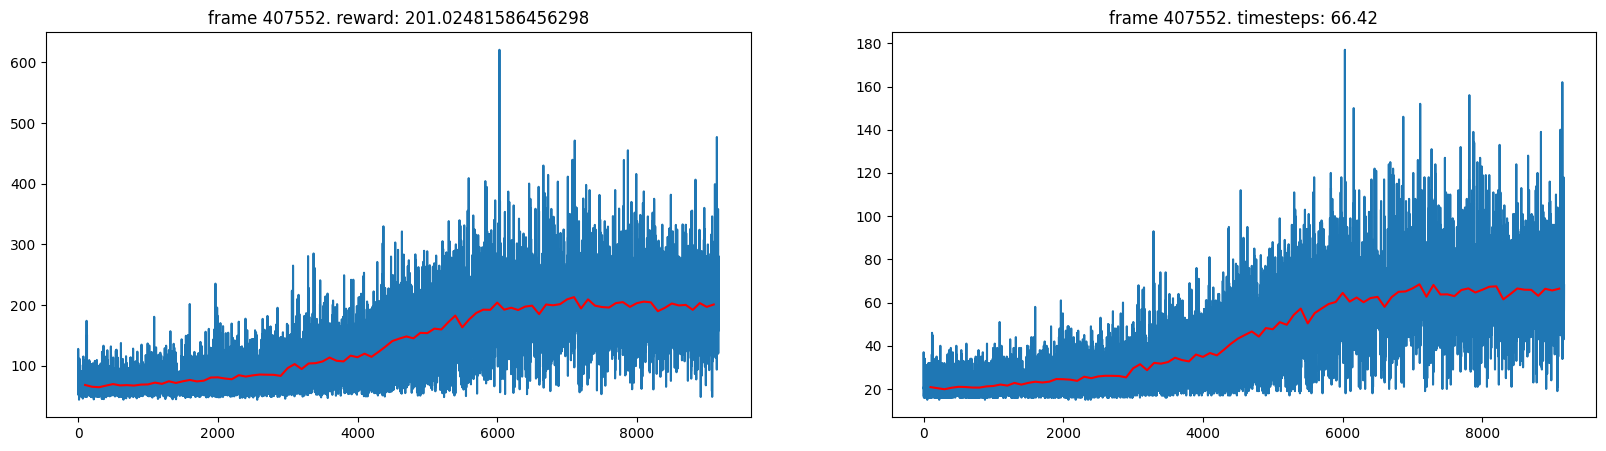

Espisode=9171, episodic_return=155.46112060546875, episodic_length=49
Espisode=9172, episodic_return=195.25802612304688, episodic_length=58
Espisode=9173, episodic_return=177.96266174316406, episodic_length=66
Espisode=9174, episodic_return=203.62637329101562, episodic_length=62
Espisode=9175, episodic_return=152.66636657714844, episodic_length=56
Espisode=9176, episodic_return=261.9775390625, episodic_length=74
Espisode=9177, episodic_return=172.34422302246094, episodic_length=57
Espisode=9178, episodic_return=218.19956970214844, episodic_length=76
Espisode=9179, episodic_return=266.8249816894531, episodic_length=78
Espisode=9180, episodic_return=273.2658996582031, episodic_length=83
Espisode=9181, episodic_return=233.90402221679688, episodic_length=81
Espisode=9182, episodic_return=187.54515075683594, episodic_length=59
Espisode=9183, episodic_return=209.95523071289062, episodic_length=67
Espisode=9184, episodic_return=154.588623046875, episodic_length=59
Espisode=9185, episodic_retu

KeyboardInterrupt: ignored

In [9]:
global_steps = 0
episode = 0
global_rewards = []
global_timesteps = []
best = -1000000
learn_iter = 0
completed = False
update_steps=0
while not completed:
  state, _ =  envs.reset()
  done = [0 for _ in range(nenvs)]
  episode_reward = 0
  for traj in range(num_trajectories):
    global_steps += nenvs
    action, dist = policy_net(torch.tensor(state, dtype=torch.float32).to(device))
    next_state, reward, termination, truncation, infos = envs.step(action.cpu().numpy())
    next_done = [trunc or term for trunc, term in zip(truncation, termination)]


    log_prob = dist.log_prob(action)
    value = v_net(torch.tensor(state, dtype=torch.float32).to(device))
    # for i in range(nenvs):
    replay.insert(np.array(state), action.cpu().detach().numpy(), np.array(reward), log_prob.cpu().detach().numpy(), value.cpu().detach().numpy(),np.array(done))
    # print(len(replay))
    
    state=next_state
    done=next_done
    # print(infos.keys())
    if np.sum(next_done):
      rq=np.array(list(envs.return_queue)[-nenvs:])[done].tolist()
      lq=np.array(list(envs.length_queue)[-nenvs:])[done].tolist()
      for i in range(len(rq)):
        print(f"Espisode={episode}, episodic_return={rq[i]}, episodic_length={lq[i]}")
        writer.add_scalar("charts/episodic_return", rq[i], episode+i)
        writer.add_scalar("charts/episodic_length", lq[i], episode+i)
      episode+=len(rq)
      global_rewards+=rq
      global_timesteps+=lq

  
  # if not global_steps % update_frequency:
  update_steps=update(batch_size, gamma, lambd, epsilon, update_iter, state, done, update_steps)
  learn_iter+=1
  
  curr_best = np.mean(global_rewards[-100:])
  if curr_best > best:
    best = curr_best
    torch.save(v_net.state_dict(), 'humanoid_1env_critic.h5')
    torch.save(policy_net.state_dict(), 'humanoid_1env_ppo_actor.h5')
  if episode > 100:
    plot(global_steps, global_rewards, global_timesteps)
  
  if curr_best >= 500:
    break
